# Extraction of features

In this script, we will look into movements within trials and extract some features that could be informative about effort.

The possible features of interest:
- duration of movement
- peaks and their amplitude - in movement, speed, acceleration
- number of peaks, ie., number of submovements
- intermittency
- gesture space


# Folder setting

In [9]:
import os
import glob
import pandas as pd

curfolder = os.getcwd()
mergedfolder = curfolder + "\\TS_merged\\"
filestotrack = glob.glob(mergedfolder + "merged_anno*.csv")

# for now we can keep only 0_2 in the list
filestotrack = [x for x in filestotrack if "0_2_" in x]

In [10]:
sample = filestotrack[20]
df = pd.read_csv(sample)

In [14]:
# lets get concept, modality and correction number out of FileInfo

df["concept"] = df["FileInfo"].apply(lambda x: x.split("_")[1])
df["modality"] = df["FileInfo"].apply(lambda x: x.split("_")[2])
df["correction"] = df["FileInfo"].apply(lambda x: x.split("_")[3])

# get rid of FileInfo
df.drop(columns=["FileInfo"], inplace=True)

In [46]:
df

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,audio,...,LWrist_vert_vel,f0,upper_body,arms,lower_body,head_mov,movement_in_trial,concept,modality,correction
0,0.0,1.121945,0.812051,1.480789,1.403169,-0.000252,-0.000123,0.000280,0_2_113_p1,0.0,...,1.149171,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
1,2.0,1.122196,0.812064,1.480782,1.403227,-0.000150,-0.000100,0.000180,0_2_113_p1,0.0,...,1.134604,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
2,4.0,1.122379,0.812091,1.480792,1.403254,-0.000064,-0.000083,0.000105,0_2_113_p1,0.0,...,1.120037,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
3,6.0,1.122505,0.812128,1.480816,1.403257,0.000007,-0.000072,0.000072,0_2_113_p1,0.0,...,1.105470,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
4,8.0,1.122583,0.812174,1.480855,1.403241,0.000065,-0.000065,0.000092,0_2_113_p1,0.0,...,1.090903,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,4560.0,1.116847,0.824376,1.546575,1.353726,-0.000165,-0.000121,0.000204,0_2_113_p1,0.0,...,3.383638,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
2281,4562.0,1.116522,0.823931,1.546296,1.353412,-0.000110,-0.000150,0.000186,0_2_113_p1,0.0,...,3.383638,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
2282,4564.0,1.116126,0.823423,1.546061,1.353080,-0.000028,-0.000204,0.000206,0_2_113_p1,0.0,...,3.383638,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0
2283,4566.0,1.115654,0.822845,1.545893,1.352729,0.000085,-0.000287,0.000299,0_2_113_p1,0.0,...,3.383638,NaN,nomovement,nomovement,nomovement,nomovement,nomovement,huilen,geluiden,c0


In [84]:
# we want just portion of moving arms

subdf = df[df["movement_in_trial"] == "movement"]    

# find peaks in COPc
import numpy as np
from scipy.signal import find_peaks

# find peaks with height of mean + 2*std
peaks, _ = find_peaks(subdf["COPc"], height=subdf["COPc"].mean())


In [87]:
# reset index
subdf.reset_index(drop=True, inplace=True)

# find the values of the peaks
peaks_values = subdf.loc[peaks, "COPc"]

In [88]:
peaks_values

# ma

26     0.003575
80     0.005218
200    0.002946
241    0.003092
Name: COPc, dtype: float64

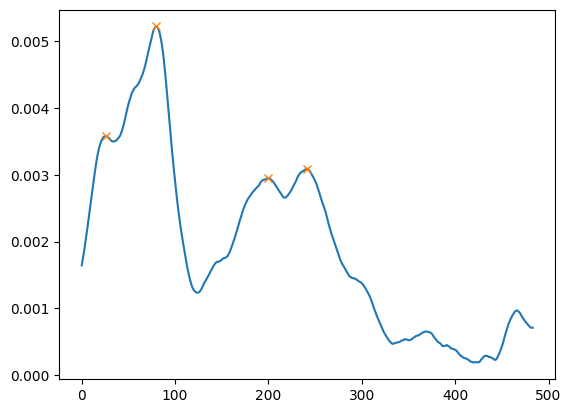

In [86]:
# plot COPc with peaks
import matplotlib.pyplot as plt

x = subdf['COPc']
plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()


In [49]:
peaks[0]

80

In [32]:
subdf

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,audio,...,LWrist_vert_vel,f0,upper_body,arms,lower_body,head_mov,movement_in_trial,concept,modality,correction


In [116]:
features_df = pd.DataFrame(columns=["duration"])

for file in filestotrack:
    print('working on file: ', file)
    df = pd.read_csv(file)
    df["concept"] = df["FileInfo"].apply(lambda x: x.split("_")[1])
    df["modality"] = df["FileInfo"].apply(lambda x: x.split("_")[2])
    df["correction"] = df["FileInfo"].apply(lambda x: x.split("_")[3])
    df.drop(columns=["FileInfo"], inplace=True)
    subdf = df[df["movement_in_trial"] == "movement"]
    # check if there is any movement in the trial
    if subdf.shape[0] > 0:
        ### duration
        duration = subdf["time"].iloc[-1] - subdf["time"].iloc[0]
    else:
        duration = 0

    ### peaks in COP
    cop_peaks, _ = find_peaks(df["COPc"], height=df["COPc"].mean())
    cop_peaks_values = df.loc[cop_peaks, "COPc"]
    cop_peaks_values = cop_peaks_values.tolist()

    ### peaks in envelope
    envelope_peaks, _ = find_peaks(df["envelope"], height=df["envelope"].mean())
    envelope_peaks_values = df.loc[envelope_peaks, "envelope"]
    envelope_peaks_values = envelope_peaks_values.tolist()


    # creta a new row with duration, concept, modality and correction
    newrow = pd.DataFrame({"duration": [duration], 'cop_peaks': [cop_peaks_values], 'env_peaks': [envelope_peaks_values], "concept": [df["concept"].iloc[0]], "modality": [df["modality"].iloc[0]], "correction": [df["correction"].iloc[0]], 'TrialID': [df['TrialID'].iloc[0]]})
    
    # concat
    features_df = pd.concat([features_df, newrow], ignore_index=True)

    

working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_111_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_112_p1.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_0_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_1_p0.csv


C:\Users\kadava\AppData\Local\Temp\ipykernel_11832\1089889436.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_df = pd.concat([features_df, newrow], ignore_index=True)


working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_2_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_3_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_4_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_5_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_6_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_7_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_8_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_9_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_10_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_11_p0.csv
working 

In [117]:
features_df

,duration,cop_peaks,env_peaks,concept,modality,correction,TrialID
0,2248.0,"[0.0082492853562105, 0.0040509692773351, 0.002...","[0.5909958817354032, 0.9999995916474298, 0.336...",ziek,geluiden,c0,0_2_111_p1
1,3864.0,"[0.0022143098481787, 0.0024616397417717, 0.002...","[0.8969312896711471, 0.9999900688750748, 0.458...",ziek,geluiden,c1,0_2_112_p1
2,2798.0,"[0.0172164931894395, 0.011067573395139, 0.0115...","[0.9593390468460228, 0.950676594794284, 0.9409...",juichen,combinatie,c0,0_2_0_p0
3,2998.0,"[0.0034313364971819, 0.0031229045703959, 0.004...","[0.823929337789921, 0.9999918719956046, 0.8041...",zingen,combinatie,c0,0_2_1_p0
4,5948.0,"[0.003822570621258, 0.0024803483914585, 0.0029...","[0.999297095802138, 0.2947470673049178, 0.0651...",vrouw,combinatie,c0,0_2_2_p0
...,...,...,...,...,...,...,...
107,1348.0,"[0.0028004743687745, 0.0025135105165011, 0.002...","[0.0602859481619622, 0.1439564414776711, 0.999...",zuigen,geluiden,c2,0_2_107_p1
108,2452.0,"[0.0021608663781204, 0.0020729947625492, 0.002...","[0.9999933933860214, 0.5067836625804046, 0.441...",dik,geluiden,c0,0_2_108_p1
109,5398.0,"[0.0012667972403353, 0.001486017686815, 0.0034...","[0.7705054888634225, 0.8675293944940834, 0.999...",dik,geluiden,c1,0_2_109_p1
110,5030.0,"[0.0037668211350997, 0.0037660934926535, 0.002...","[0.966502383713861, 0.9999709449619726, 0.4005...",dik,geluiden,c2,0_2_110_p1


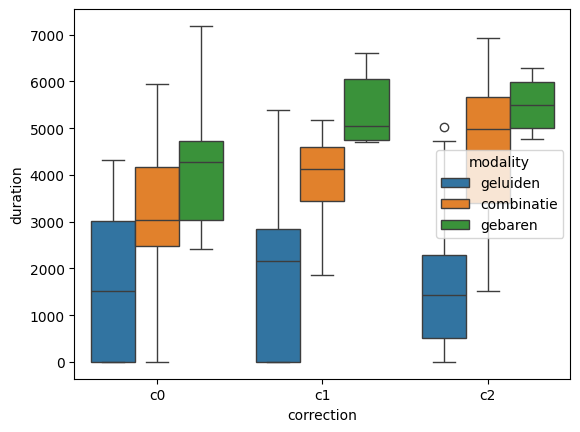

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt


### plotting duration

sns.boxplot(x="correction", y="duration", data=features_df, hue="modality")
plt.show()


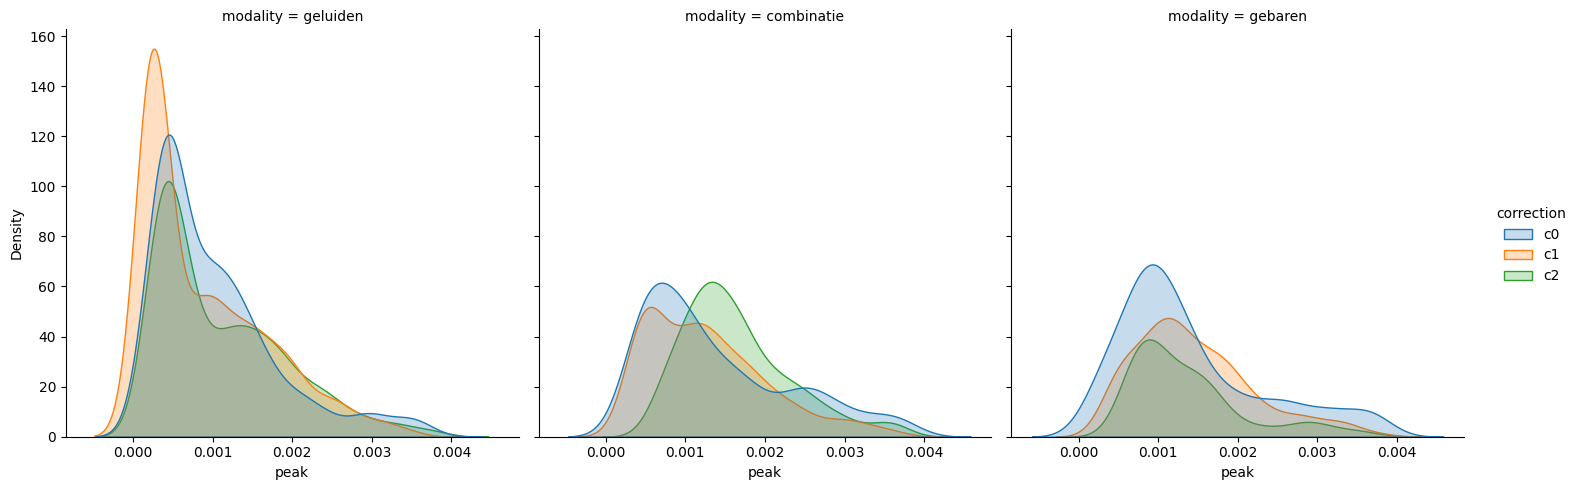

In [132]:

### plotting peaks in COPc

flat_data = []

for _, row in features_df.iterrows():
    for peak in row['cop_peaks']:
        flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)

# get rid of outliers based on Tukey's fences
Q1 = flat_df["peak"].quantile(0.25)
Q3 = flat_df["peak"].quantile(0.75)
IQR = Q3 - Q1
flat_df = flat_df[(flat_df["peak"] > (Q1 - 1.5 * IQR)) & (flat_df["peak"] < (Q3 + 1.5 * IQR))]

# plot 
sns.displot(flat_df, x="peak", col="modality", hue='correction', kind="kde", fill=True)
plt.show()


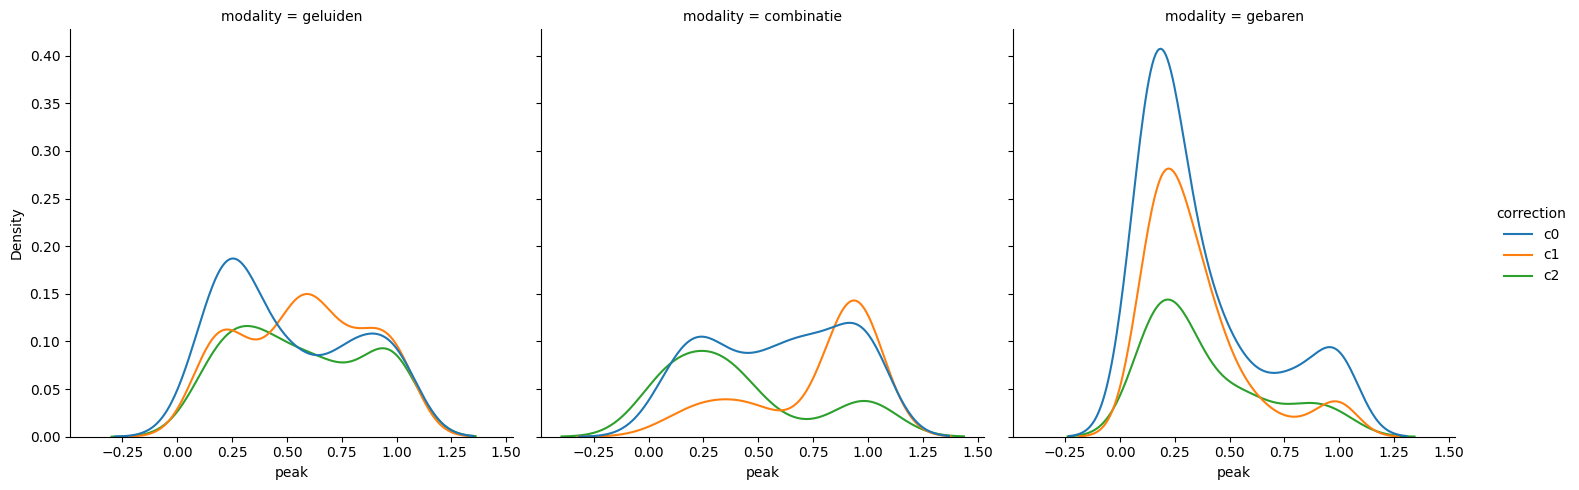

In [130]:
### plotting peaks in envelope

flat_data = []

for _, row in features_df.iterrows():
    for peak in row['env_peaks']:
        flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)

# plot each modality separately in a grid, hue by correction
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")